In [1]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
!cd yolov5

# Install dependencies
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16680, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 16680 (delta 102), reused 131 (delta 61), pack-reused 16459
Receiving objects: 100% (16680/16680), 15.32 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (11408/11408), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib
!pip install seaborn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
! pip install pillow
! pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00


In [4]:
import os
from PIL import Image
from rembg import remove

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 이미지 불러오기
image = Image.open("/content/drive/MyDrive/DL project/wedding_dress/cloth/20925_00.jpg")
# 배경 제거
output_image = remove(image)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 111GB/s]


In [ ]:
# PIL 이미지를 numpy 배열로 변환
output_image_np = np.array(output_image)

# RGBA로 변환 (배경 제거된 이미지는 알파 채널을 포함할 수 있음)
if output_image_np.shape[2] == 3:  # 만약 알파 채널이 없다면
    output_image_np = cv2.cvtColor(output_image_np, cv2.COLOR_RGB2RGBA)

# numpy 배열을 OpenCV 이미지로 변환
clothing_img = output_image_np

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-18 Python-3.10.12 torch-2.3.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


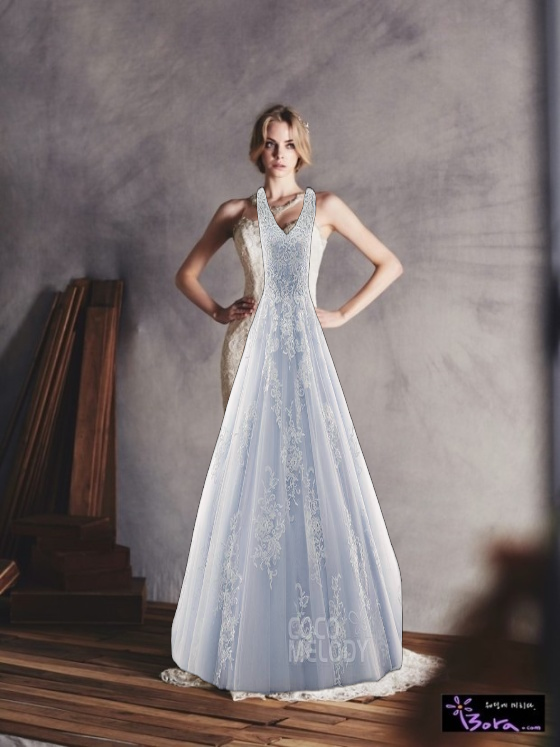

In [ ]:
##### 길이만 맞춰서 냅다 붙이기 -> 바운딩 박스 안에서만 옷을 입혀서 벨라인 같이 부피감이 큰 것은 옷이 가로로 축소되서 붙여짐...
from PIL import Image
import numpy as np
import cv2
import torch
from rembg import remove
from google.colab.patches import cv2_imshow

# YOLOv5 모델 불러오기
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

def load_image(img_path):
    img = cv2.imread(img_path)
    return img

def detect_person(img):
    results = model(img)
    # 사람이 감지된 바운딩 박스 정보 가져오기
    person_boxes = []
    for *box, conf, cls in results.xyxy[0].cpu().numpy():
        if int(cls) == 0:  # 0: person
            person_boxes.append(box)
    return person_boxes

def overlay_clothing(person_img, clothing_img, box):
    x1, y1, x2, y2 = map(int, box)
    w, h = x2 - x1, y2 - y1
    clothing_img = cv2.resize(clothing_img, (w, h))
    alpha_s = clothing_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        person_img[y1:y2, x1:x2, c] = (alpha_s * clothing_img[:, :, c] + alpha_l * person_img[y1:y2, x1:x2, c])

    return person_img

# 이미지 로드
person_img = load_image("/content/drive/MyDrive/DL project/wedding_dress/image/20071_00.jpg")

# 옷 이미지 불러오기 및 배경 제거
clothing_image_path = "/content/drive/MyDrive/DL project/wedding_dress/cloth/20925_00.jpg"
clothing_pil_img = Image.open(clothing_image_path)
output_image = remove(clothing_pil_img)

# PIL 이미지를 numpy 배열로 변환
output_image_np = np.array(output_image)

# RGBA로 변환 (배경 제거된 이미지는 알파 채널을 포함할 수 있음)
if output_image_np.shape[2] == 3:  # 만약 알파 채널이 없다면
    output_image_np = cv2.cvtColor(output_image_np, cv2.COLOR_RGB2RGBA)

# numpy 배열을 OpenCV 이미지로 변환
clothing_img = output_image_np

# 사람 인식
person_boxes = detect_person(person_img)

# 옷 합성
for box in person_boxes:
    person_img = overlay_clothing(person_img, clothing_img, box)

# 결과 이미지 저장 및 표시
cv2.imwrite("output.jpg", person_img)
cv2_imshow(person_img)

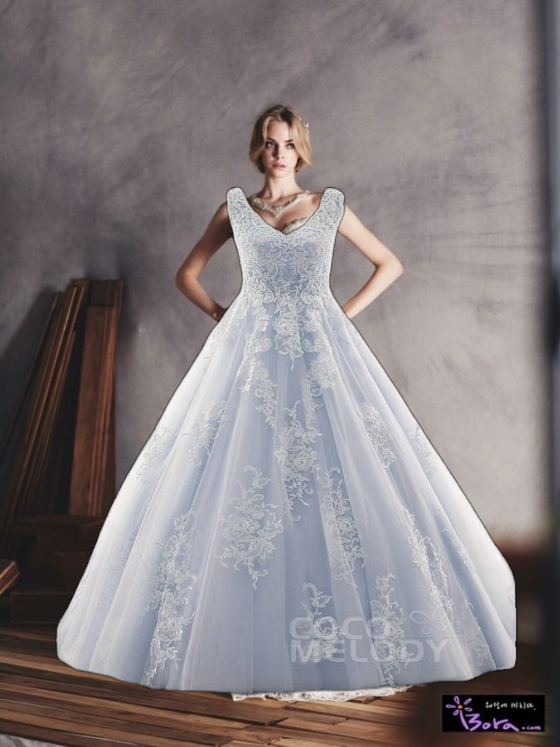

In [ ]:
# 오버레이
def overlay_clothing(person_img, clothing_img, box): # 옷이 벗어나면 안됨. 아래 코드 이용해서 다시 돌려바
    x1, y1, x2, y2 = map(int, box)
    person_height = y2 - y1

    # 옷 이미지의 크기를 사람의 높이에 맞추기 (폭은 유지)
    scale_factor = person_height / clothing_img.shape[0]
    new_height = person_height
    new_width = int(clothing_img.shape[1] * scale_factor)
    resized_clothing_img = cv2.resize(clothing_img, (new_width, new_height))

    # 옷 이미지를 중앙에 배치
    center_x = x1 + (x2 - x1) // 2
    top_left_x = center_x - new_width // 2
    top_left_y = y1

    # 알파 채널 분리
    alpha_s = resized_clothing_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        person_img[top_left_y:top_left_y+new_height, top_left_x:top_left_x+new_width, c] = \
            (alpha_s * resized_clothing_img[:, :, c] + alpha_l * person_img[top_left_y:top_left_y+new_height, top_left_x:top_left_x+new_width, c])

    return person_img

# 이미지 로드
person_img = load_image("/content/drive/MyDrive/DL project/wedding_dress/image/20071_00.jpg")

# 옷 이미지 불러오기 및 배경 제거
clothing_image_path = "/content/drive/MyDrive/DL project/wedding_dress/cloth/20925_00.jpg"
clothing_pil_img = Image.open(clothing_image_path)
output_image = remove(clothing_pil_img)

# PIL 이미지를 numpy 배열로 변환
output_image_np = np.array(output_image)

# RGBA로 변환 (배경 제거된 이미지는 알파 채널을 포함할 수 있음)
if output_image_np.shape[2] == 3:  # 만약 알파 채널이 없다면
    output_image_np = cv2.cvtColor(output_image_np, cv2.COLOR_RGB2RGBA)

# numpy 배열을 OpenCV 이미지로 변환
clothing_img = output_image_np

# 사람 인식
person_boxes = detect_person(person_img)

# 옷 합성
for box in person_boxes:
    person_img = overlay_clothing(person_img, clothing_img, box)

# 결과 이미지 저장 및 표시
cv2.imwrite("output.jpg", person_img)
cv2_imshow(person_img)

In [7]:
from PIL import Image
import numpy as np
import cv2
import torch
from rembg import remove
from google.colab.patches import cv2_imshow

# YOLOv5 모델 불러오기
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

def load_image(img_path):
    img = cv2.imread(img_path)
    return img

def detect_person(img):
    results = model(img)
    # 사람이 감지된 바운딩 박스 정보 가져오기
    person_boxes = []
    for *box, conf, cls in results.xyxy[0].cpu().numpy():
        if int(cls) == 0:  # 0: person
            person_boxes.append(box)
    return person_boxes

def overlay_clothing(person_img, clothing_img, box):
    x1, y1, x2, y2 = map(int, box)
    person_height = y2 - y1

    # 옷 이미지의 크기를 사람의 높이에 맞추기 (폭은 유지)
    scale_factor = person_height / clothing_img.shape[0]
    new_height = person_height
    new_width = int(clothing_img.shape[1] * scale_factor)
    resized_clothing_img = cv2.resize(clothing_img, (new_width, new_height))

    # 옷 이미지를 중앙에 배치
    center_x = x1 + (x2 - x1) // 2
    top_left_x = center_x - new_width // 2
    top_left_y = y1

    # 경계를 벗어나는 부분 처리
    end_y = top_left_y + new_height
    end_x = top_left_x + new_width

    if end_y > person_img.shape[0]:
        resized_clothing_img = resized_clothing_img[:person_img.shape[0] - top_left_y, :]
        end_y = person_img.shape[0]

    if end_x > person_img.shape[1]:
        resized_clothing_img = resized_clothing_img[:, :person_img.shape[1] - top_left_x]
        end_x = person_img.shape[1]

    if top_left_y < 0:
        resized_clothing_img = resized_clothing_img[-top_left_y:, :]
        top_left_y = 0

    if top_left_x < 0:
        resized_clothing_img = resized_clothing_img[:, -top_left_x:]
        top_left_x = 0


    # 알파 채널 분리
    alpha_s = resized_clothing_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    # 합성할 영역 계산
    for c in range(0, 3):
        person_img[top_left_y:top_left_y+new_height, top_left_x:top_left_x+new_width, c] = \
            (alpha_s * resized_clothing_img[:, :, c] + alpha_l * person_img[top_left_y:top_left_y+new_height, top_left_x:top_left_x+new_width, c])

    return person_img

# 이미지 로드
person_img = load_image("/content/drive/MyDrive/DLproject/final2.jpg")

# 옷 이미지 불러오기 및 배경 제거
clothing_image_path = "/content/drive/MyDrive/DLproject/wedding_dress/cloth/20004_00.jpg"
clothing_pil_img = Image.open(clothing_image_path)
output_image = remove(clothing_pil_img)

# PIL 이미지를 numpy 배열로 변환
output_image_np = np.array(output_image)

# RGBA로 변환 (배경 제거된 이미지는 알파 채널을 포함할 수 있음)
if output_image_np.shape[2] == 3:  # 만약 알파 채널이 없다면
    output_image_np = cv2.cvtColor(output_image_np, cv2.COLOR_RGB2RGBA)

# numpy 배열을 OpenCV 이미지로 변환
clothing_img = output_image_np

# 사람 인식
person_boxes = detect_person(person_img)

# 옷 합성
for box in person_boxes:
    person_img = overlay_clothing(person_img, clothing_img, box)

# 결과 이미지 저장 및 표시
cv2.imwrite("output.jpg", person_img)
cv2_imshow(person_img)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-25 Python-3.10.12 torch-2.3.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


UnidentifiedImageError: cannot identify image file '/content/drive/MyDrive/DLproject/wedding_dress/cloth/20004_00.jpg'

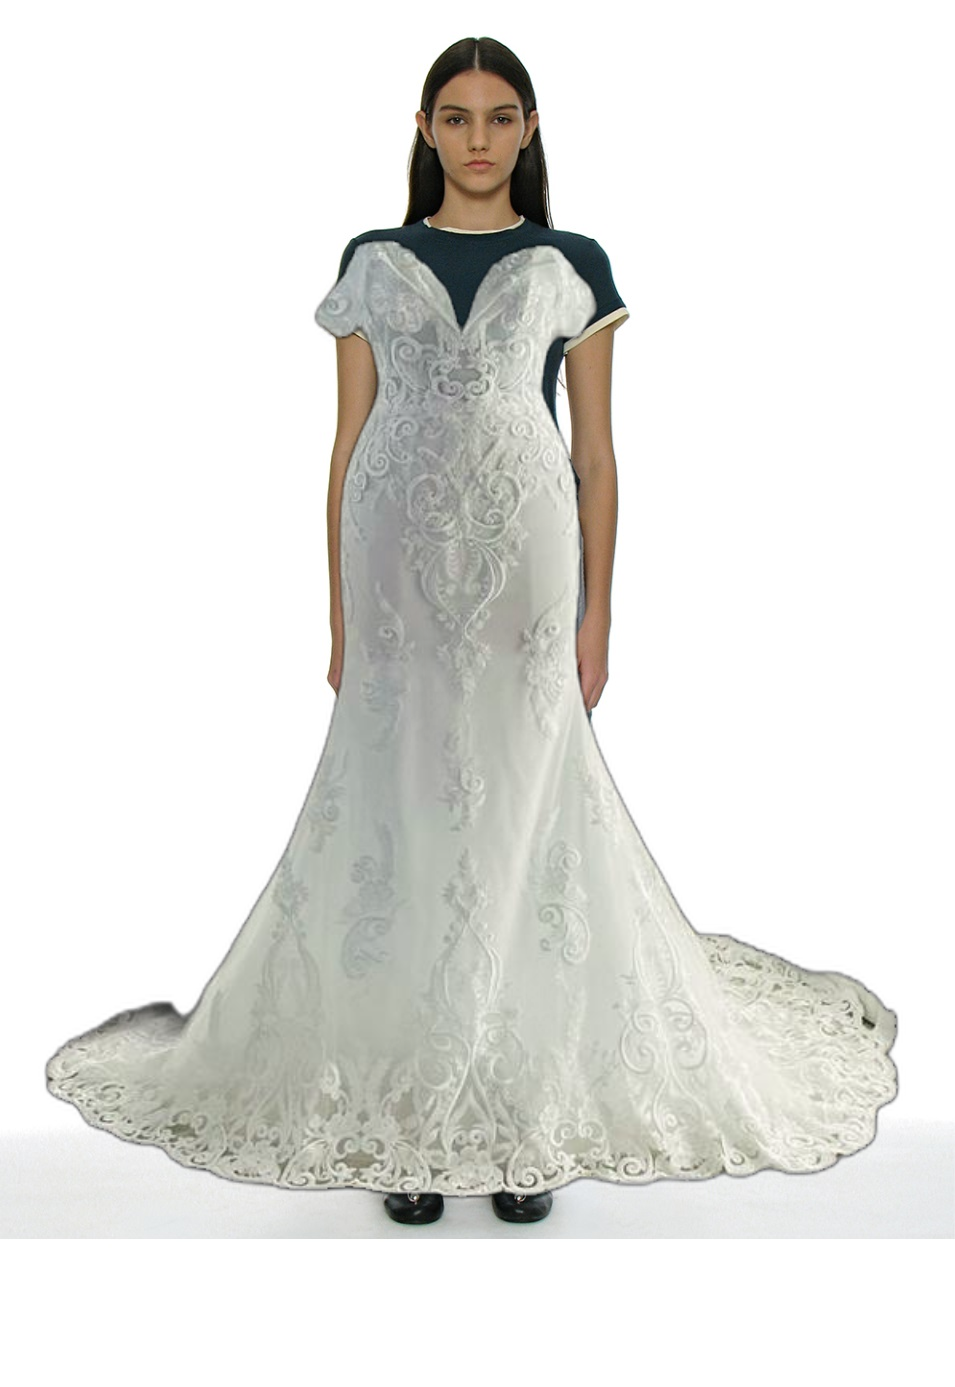

In [ ]:
# 이미지 로드
person_img = load_image("/content/drive/MyDrive/DL project/person8.jpg")

# 옷 이미지 불러오기 및 배경 제거
clothing_image_path = "/content/drive/MyDrive/DL project/wedding_dress/cloth/20842_00.jpg"
clothing_pil_img = Image.open(clothing_image_path)
output_image = remove(clothing_pil_img)

# PIL 이미지를 numpy 배열로 변환
output_image_np = np.array(output_image)

# RGBA로 변환 (배경 제거된 이미지는 알파 채널을 포함할 수 있음)
if output_image_np.shape[2] == 3:  # 만약 알파 채널이 없다면
    output_image_np = cv2.cvtColor(output_image_np, cv2.COLOR_RGB2RGBA)

# numpy 배열을 OpenCV 이미지로 변환
clothing_img = output_image_np

# 사람 인식
person_boxes = detect_person(person_img)

# 옷 합성
for box in person_boxes:
    person_img = overlay_clothing(person_img, clothing_img, box)

# 결과 이미지 저장 및 표시
cv2.imwrite("output.jpg", person_img)
cv2_imshow(person_img)